# setting up the environement

In [2]:
!pip install pyarabic
!pip install Arabic-Stopwords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 3.8 MB/s eta 0:00:00


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabicstopwords.arabicstopwords as stp
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Loading dataset

In [4]:
SEED = 21
dataset = pd.read_csv("./datasets/LABR/reviews.tsv", sep = '\t', header=None, names = ["rating","review_id","user_id","book_id","review"])
dataset.head(20)

,rating,review_id,user_id,book_id,review
0,4,338670838,7878381,13431841,"""عزازيل الذي صنعناه ،الكامن في أنفسنا"" يذكرني..."
1,4,39428407,1775679,3554772,من أمتع ما قرأت من روايات بلا شك. وحول الشك ت...
2,4,32159373,1304410,3554772,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ...
3,1,442326656,11333112,3554772,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أس...
4,5,46492258,580165,3554772,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالع...
5,5,25550893,1252226,3554772,"""عزازيل"" هو اسم رواية يوسف زيدان الثانية و ال..."
6,3,196205720,4407762,3554772,لم استوعب بداية أنها رواية حتى وصلت إلى المنت...
7,4,73211467,2717148,3554772,هذا هو الأدب . هذه هي الرواية !
8,4,173066107,5068872,3554772,مقتطفات من رواية عزازيل للكاتب يوسف زيدان ---...
9,5,417973056,7817769,3554772,في البداية.ولكن بداية مشوقة للغاية.يبدو انني ...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63257 entries, 0 to 63256
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating     63257 non-null  int64 
 1   review_id  63257 non-null  int64 
 2   user_id    63257 non-null  int64 
 3   book_id    63257 non-null  int64 
 4   review     63257 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.4+ MB


In [9]:
# checking for the distribution of the ratings
print(dataset['rating'].value_counts(normalize=True) * 100)

rating
5    37.589516
4    30.121568
3    19.287984
2     8.354807
1     4.646126
Name: proportion, dtype: float64


## Reviews distribution

Axes(0.125,0.11;0.775x0.77)


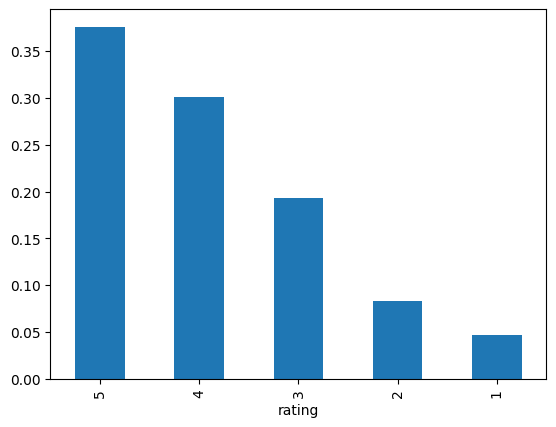

In [10]:
print(dataset['rating'].value_counts(normalize=True).plot(kind='bar'))

# Data preprocessing

## Rmoving unnecessary columns

In [11]:
dataset = dataset.drop(['review_id','user_id','book_id'], axis=1)

## Removing duplicate entries

In [12]:
dataset = dataset.drop_duplicates(subset='review', keep='first')

In [13]:
# removing whitespaces
import re
pattern = r'\s+|\n+'
dataset["review"] = dataset["review"].apply(lambda document: re.sub(pattern, ' ', document))

In [14]:
# removing punctuations

pattern = r'[^\w\s\u0600-\u06FF]+|ﷺ|۩|⓵|؟|۞|ﷻ'
dataset["review"] = dataset["review"].apply(lambda document: re.sub(pattern, '', document))

In [15]:
# removing consecutive characters in arabic

pattern = r'(.)\1+'
dataset["review"] = dataset["review"].apply(lambda document: re.sub(pattern, r'\1', document))

In [16]:
# removing stop words

stop_words = set(stopwords.words('arabic'))
stop_words.update(stp.stopwords_list())
dataset["review"] = dataset["review"].apply(lambda document: ' '.join([word for word in document.split() if word not in stop_words]))

In [17]:
# removing arabic diactrics

dataset["review"] = dataset["review"].apply(lambda document: araby.strip_tashkeel(document))

In [18]:
# removing numbers

dataset["review"] = dataset["review"].apply(lambda document: ''.join([i for i in document if not i.isdigit()]))

In [19]:
# removing english alphabets

dataset["review"] = dataset["review"].apply(lambda document: re.sub(r'[a-zA-Z]+', '', document))

In [20]:
# tokenizing the reviews using nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

dataset["review"] = dataset["review"].apply(lambda document: word_tokenize(document))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# stemming the reviews using nltk

stemmer = ISRIStemmer()
dataset["review"] = dataset["review"].apply(lambda document: [stemmer.stem(word) for word in document])

In [22]:
# checking the first 20 rows of the dataset

dataset.head(20)

,rating,review
0,4,"[عزازيل, صنع, ،الكام, ذكر, وسف, زيد, بـ, رخس, ..."
1,4,"[متع, قرأ, روي, شك, الش, دند, عزازيل, هود, حمد..."
2,4,"[روي, ارخ, ،جا, خار, ؤلف, فتر, ارخ, ندر, نول, ..."
3,1,"[قدر, روي, كثيرا،, لسب, خلف, سبب, خرين،, علم, ..."
4,5,"[كهن, طلق, اسم, هيب, تيم, علم, وثن, هيب, فر, ق..."
5,5,"[عزازيل, اسم, روي, وسف, زيد, ثني, صدر, ؤخر, دا..."
6,3,"[وعب, بدي, روي, وصل, نصف, قرب, قرأ, كان, وقع, ..."
7,4,"[ادب, روي]"
8,4,"[قطف, روي, عزازيل, كتب, وسف, زيد, خار, وان, شي..."
9,5,"[دايةول, بدي, شوق, لغايةيبدو, اني, وقع, كنز, ا..."


## Saving the preprocessed data

In [ ]:
dataset.to_csv("preprocessed_data.csv")

# Text representation
## BoW (Bag-of-Words)

In [30]:
X_train , X_test , y_train , y_test = train_test_split(dataset['review'], dataset['rating'], test_size = 0.2, random_state = SEED)

In [32]:
# creating the bag of words model

cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

## Performance evaluation

In [33]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# training the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# making predictions
y_pred = gnb.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"The accuracy of the model is: {accuracy}")


The accuracy of the model is: 0.1288899983358296


In [ ]:
# logistic regression

from sklearn.linear_model import LogisticRegression

# training the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# making predictions
y_pred = lr.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is: {accuracy}")

In [ ]:
# SVM 



scaler = StandardScaler()
svm = SVC()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

componenets = [100, 200, 500]
scores = []
for n_components in componenets:
    pca = PCA(n_components = n_components)
    X_train_SVM = pca.fit_transform(scaled_X_train)
    X_test_SVM  = pca.transform(scaled_X_test)

    svm.fit(X_train_SVM, y_train)
    y_pred = svm.predict(X_test_SVM)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

plt.plot(componenets, scores)
plt.xlabel('# of componenets')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# training the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# making predictions
y_pred = rf.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is: {accuracy}")

## TF-IDF

In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

X_train , X_test , y_train , y_test = train_test_split(dataset['review'], dataset['rating'], test_size = 0.2, random_state = SEED)

# creating the TF-IDF model 

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

### Performance Evaluation

In [ ]:
# logistic regression

from sklearn.linear_model import LogisticRegression

# training the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# making predictions
y_pred = lr.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"The accuracy of the model is: {accuracy}")

In [ ]:
# naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# training the model
gnb = MultinomialNB()
gnb.fit(X_train, y_train)

# making predictions
y_pred = gnb.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is: {accuracy}")

In [ ]:
# SVM 
scaler = StandardScaler()
pca = PCA(n_components = 200)
svm = SVC()

X_train_SVM = pca.fit_transform(scaler.fit_transform(X_train.copy()))
X_test_SVM = pca.transform(scaler.transform(X_test.copy()))

y_train_SVM = y_train
y_test_SVM = y_test

svm.fit(X_train_SVM, y_train_SVM)
y_pred = svm.predict(X_test_SVM)
accuracy = accuracy_score(y_test_SVM, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Random Forest 

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy * 100:.2f}%")

## LDA

In [ ]:
# LDA 
X_train, X_test, y_train, y_test = train_test_split(data["review"], data["rating"], test_size = 0.2, random_state = SEED, stratify = data["rating"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

lda = LatentDirichletAllocation(n_components = 170, random_state = SEED)
lda.fit(X_train)
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

## LSA

In [ ]:
lsa = TruncatedSVD(n_components = 10, random_state = SEED)
X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.transform(X_test)
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_lsa, y_train)
y_pred = model.predict(X_test_lsa)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

## Bag of Concepts

## Word Embeddings

In [ ]:
model = gensim.models.Word2Vec.load("./aravec/tweets_cbow_300")
word_vecs = {}
for tweet in data["tweet"]:
    for word in tweet.split(" "):
        try:
            word_vecs[word] = model.wv[word]
        except Exception:
            pass

## Clustering the words embeddings


In [ ]:
NUM_CONCEPTS = 80

model = KMeans(n_clusters = NUM_CONCEPTS)
X = list(word_vecs.values())
model.fit(X)
concepts = model.predict(X)

## Concept Extraction

In [ ]:
NUM_DOCS = data.shape[0]

# construct a word to concept mapping
word_concept = {}
for index, word in enumerate(word_vecs.keys()):
    word_concept[word] = concepts[index]
print(word_concept)

In [ ]:
# construct a concept to document count mapping
concept_docs = defaultdict(int)
for doc in data["tweet"]:
    doc_concepts = set()
    for word in doc.split(" "):
        try:
            doc_concepts.add(word_concept[word])
        except Exception:
            pass
    for concept in doc_concepts:
        concept_docs[concept] += 1
print(concept_docs)

In [ ]:
def cf_idf(document: str):
    """ Returns the CD-IDF representataion of a document """
    res = [0 for _ in range(NUM_CONCEPTS)]
    concepts_counts = defaultdict(int)
    for word in document.split(" "):
        try:
            concepts_counts[word_concept[word]] += 1
        except:
            pass
    n_k = sum(concepts_counts.values()) # number of concepts present in the document (duplicates are considered!)
    for concept in range(NUM_CONCEPTS):
        if concepts_counts[concept] != 0:
            res[concept] = (concepts_counts[concept] / n_k) * log(NUM_DOCS / (1 + concept_docs[concept]))
    return res

In [ ]:
X = [cf_idf(tweet) for tweet in data["tweet"]]
y = data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

### Performance Evaluation

In [ ]:
# Naive Bayes

model = GaussianNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Logistic Regression

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# SVM 
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")